# Estimating biomarker ordering

>The sampler for the biomarker ordering can be a bit tricker. The simplest way to do it might be to do a Metropolis-Hastings step where you select two indicies and propose swapping their order. Then you can work out the relative probabilities, evaluate and then accept/reject based on that. It's not the fastest sampler, but it is a lot more straightforward than some ways of doing it.  

In the following, we assume we know the actual $\theta$ and $\phi$ values. Other than those, we know nothing except for participants' observed biomarker values. And we want to estimate the current order in which different biomarkers are affected by the disease in question. 

In [237]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
import math

We only have three columns: biomarker, participant, and measurement. 

In [238]:
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data['Diseased'] = data.apply(lambda row: row.k_j > 0, axis = 1)
data.sample(5)

,Biomarker,participant,measurement,k_j,S_n,affected_or_not,Diseased
975,9,75,36.577947,0,7,not_affected,False
653,6,53,36.557957,0,10,not_affected,False
702,7,2,33.286502,3,5,not_affected,True
916,9,16,37.304066,4,7,not_affected,True
200,2,0,4.896114,10,8,affected,True


In [239]:
## These are the healthy participants (Participant ID)
non_diseased_participants = list(set(data.loc[data.Diseased == False].participant))
non_diseased_participants

[96, 33, 36, 73, 75, 77, 79, 19, 53, 92]

In [240]:
3 in non_diseased_participants

False

In [241]:
data_we_have = data.drop(['k_j', 'S_n', 'affected_or_not'], axis = 1)
data_we_have.head()

,Biomarker,participant,measurement,Diseased
0,0,0,1.264582,True
1,0,1,0.855712,True
2,0,2,1.609533,True
3,0,3,1.276995,True
4,0,4,0.967875,True


In [242]:
theta_phi = pd.read_csv('data/means_stds.csv')
theta_phi.head()

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,0,1.0,0.3,32.0,6.3
1,1,3.0,0.5,31.0,7.4
2,2,5.0,0.2,34.0,9.4
3,3,6.0,1.3,36.0,4.9
4,4,8.0,3.3,38.0,2.5


In [243]:
type(theta_phi['biomarker'][0])

numpy.int64

In [244]:
def fill_up_pdata(pdata, k_j):
    '''Fill up a single participant's data using k_j; basically add two columns: 
    k_j and affected
    Note that this function assumes that pdata already has the S_n column
    
    Input:
    - pdata: a dataframe of ten biomarker values for a specific participant 
    - k_j: a scalar
    '''
    data = pdata.copy()
    data['k_j'] = k_j
    data['affected'] = data.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data 

In [245]:
def compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the measurement value of a single biomarker
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    std = biomarker_params['theta_std'][0] if affected else biomarker_params['phi_std'][0]
    var = std**2
    likelihood = np.exp(-(measurement - mu)**2/(2*var))/np.sqrt(2*np.pi*var)
    return likelihood

In [246]:
def compute_likelihood(pdata, k_j, theta_phi):
    '''This implementes the formula of https://ebm-book2.vercel.app/distributions.html#known-k-j
    This function computes the likelihood of seeing this sequence of biomarker values for a specific participant
    '''
    data = fill_up_pdata(pdata, k_j)
    likelihood = 1
    for i, row in data.iterrows():
        biomarker = int(row['Biomarker'])
        measurement = row['measurement']
        affected = row['affected']
        likelihood *= compute_single_measurement_likelihood(
            theta_phi, biomarker, affected, measurement)
    return likelihood

## Testing

The above functions can compute the likelihood of a participant's sequence of biomarker data, given that we know the exact ordering and we assume a `k_j`. Next, we will test those functions by selecting a specific participant. We compute the likelihood by trying all possible `k_j` and see whether the one with the highest likelihood is the real `k_j` in the original data. 

In [247]:
p = 15 # we chose this participant
pdata = data[data.participant == p].reset_index(drop=True)
pdata

,Biomarker,participant,measurement,k_j,S_n,affected_or_not,Diseased
0,0,15,1.711735,1,1,affected,True
1,1,15,40.574877,1,6,not_affected,True
2,2,15,39.415650,1,8,not_affected,True
3,3,15,37.535220,1,3,not_affected,True
4,4,15,38.406740,1,4,not_affected,True
5,5,15,41.627635,1,2,not_affected,True
6,6,15,27.464651,1,10,not_affected,True
7,7,15,50.146766,1,5,not_affected,True
8,8,15,19.188532,1,9,not_affected,True
9,9,15,38.043530,1,7,not_affected,True


In [248]:
# ordering of biomarker affected by the disease
# biomarker: disease stage
# note that the value >= 1
real_ordering_dic = dict(zip(np.arange(10), pdata.S_n))
real_ordering_dic

{0: 1, 1: 6, 2: 8, 3: 3, 4: 4, 5: 2, 6: 10, 7: 5, 8: 9, 9: 7}

In [249]:
# get the participant data without k_j, and affected or not
pdata = data_we_have[data_we_have.participant == p].reset_index(drop=True)
# obtain real ordering:
pdata['S_n'] = pdata.apply(lambda row: real_ordering_dic[int(row['Biomarker'])], axis = 1)
pdata

,Biomarker,participant,measurement,Diseased,S_n
0,0,15,1.711735,True,1
1,1,15,40.574877,True,6
2,2,15,39.415650,True,8
3,3,15,37.535220,True,3
4,4,15,38.406740,True,4
5,5,15,41.627635,True,2
6,6,15,27.464651,True,10
7,7,15,50.146766,True,5
8,8,15,19.188532,True,9
9,9,15,38.043530,True,7


In [250]:
num_biomarkers = len(pdata.Biomarker.unique())
# calculate likelihood for all possible k_j
likelihood_list = [
    compute_likelihood(pdata=pdata, k_j=x, theta_phi=theta_phi) for x in range(num_biomarkers+1)]
kjs = np.arange(11)
dic = dict(zip(kjs, likelihood_list))
df = pd.DataFrame.from_dict(dic, orient='index', columns=['likelihood']).reset_index()
df.sort_values('likelihood', ascending=False)

,index,likelihood
1,1,1.107592e-14
0,0,8.420188e-20
2,2,5.900480e-92
3,3,3.885945e-219
4,4,1.093186e-237
5,5,0.000000e+00
6,6,0.000000e+00
7,7,0.000000e+00
8,8,0.000000e+00
9,9,0.000000e+00


<!-- From the above result, we can see that the most likelihood `k_j` is 8, which is in fact the real `k_j` in the participant data.  -->

## Metropolis-Hastings Algorithm Implementation

Next, we will implement the metropolis-hastings algorithm using the above functions. 

In [251]:
def average_all_likelihood(pdata, num_biomarkers, theta_phi):
    '''This is to compute https://ebm-book2.vercel.app/distributions.html#unknown-k-j
    '''
    return np.mean([compute_likelihood(pdata=pdata, k_j=x, theta_phi=theta_phi) for x in range(num_biomarkers+1)])

In [252]:
def compute_ln_likelihood_assuming_ordering(ordering, data, num_participants, num_biomarkers, theta_phi):
    """Compute the (ln version of) the likelihood of seeing all participants' data,
    assuming that we already know the ordering
    Inputs:
        - ordering: an array of ordering for biomarker 0-9
        - data: data_we_have
        - num_participants
        - num_biomarkers 
    Outputs:
        - ln(likelihood)
    """
    # biomarker - order dict
    ordering_dic = dict(zip(np.arange(num_biomarkers), ordering))
    # fill up S_n column using the ordering dict
    # copy first in order not to change data_we_have
    filled_data = data.copy()
    filled_data['S_n'] = filled_data.apply(lambda row: ordering_dic[int(row['Biomarker'])], axis = 1)
    ln_likelihood = 0 
    for p in range(num_participants):
        pdata = filled_data[filled_data.participant == p].reset_index(drop=True)
        average_likelihood = average_all_likelihood(pdata, num_biomarkers, theta_phi)
        p_ln_likelihood = (
            # natural logarithm
           np.log(average_likelihood) 
           if average_likelihood > 0
           # this is to avoid np.log(0)
           else np.log(average_likelihood + 1e-20)
        )
        ln_likelihood += p_ln_likelihood
    return ln_likelihood

A brush up on log:

$L = P1 \cdot P2 \cdot P3$

$\ln(L) = \ln (P1 \cdot P2 \cdot P3) = \ln(P1) + \ln(P2) + \ln(P3)$

You may wonder why above I am using the second equation to get the likelihood of observing a specific participant's data. This is because if we want to estimate $k_j$, we need to know $S$, which we do not know and are trying to estimate here. 

If we want to estimate $S$ through using the first equation, we need $k_j$, but we do not know it. 

To sum up, to obtain $S$, we need to know $k_j$. And to obtain $k_j$, we need to know $S$. Therefore, we are not able to use the first equation. 

In [253]:
def metropolis_hastings(data, iterations, theta_phi):
    '''Implement the metropolis-hastings algorithm
    Inputs: 
        - data: data_we_have
        - iterations: number of iterations

    Outputs:
        - best_order: a numpy array
        - best_likelihood: a scalar 
    '''
    num_participants = len(data.participant.unique())
    num_biomarkers = len(data.Biomarker.unique())

    # initialize an ordering and likelihood
    # note that it should be a random permutation of numbers 1-10
    best_order = np.random.permutation(np.arange(1, 11))
    best_likelihood = -np.inf 
    # best_order = np.array(list(real_ordering_dic.values()))
    # best_likelihood = compute_likelihood_based_on_ordering(
    #     best_order, data, num_participants, num_biomarkers, theta_phi
    # )
    for _ in range(iterations):
        new_order = best_order.copy()
        # randomly select two indices
        a, b = np.random.choice(num_biomarkers, 2, replace=False)
        # swapping the order
        new_order[a], new_order[b] = new_order[b], new_order[a]
        ln_likelihood = compute_ln_likelihood_assuming_ordering(
            new_order, data, num_participants, num_biomarkers, theta_phi)
        # if swapping results in higher likelihood, 
        # update the likelihood and accept the new ordering 
        if ln_likelihood > best_likelihood:
            best_likelihood = ln_likelihood 
            best_order = new_order
        else: 
            # ratio = likelihood/best_likelihood
            # np.exp(a - b) = np.exp(a)/np.exp(b)
            acceptance_ratio = np.exp(ln_likelihood - best_likelihood)
            random_number = np.random.rand()
            if random_number < acceptance_ratio:
                best_likelihood = ln_likelihood
                best_order = new_order
        print(f"iteration {_ + 1} done")
    return best_order, best_likelihood


When `ln_likelihood` is smaller than `best_likelihood`, we still conditionally accept `ln_likelihood`. This is "to allow exploration of the parameter space. This step is crucial in MCMC algorithms to avoid getting stuck in local maxima and to ensure that the sampling covers the entire distribution space adequately".

Note that the condition is `if random_number < acceptance_ratio`. This `<` cannot be changed to `>`. Why?

When the `accepatance_ratio` is small, then it indicates `ln_likelihood` is small. We do not want to accept this `ln_likelihood` in this case. Because `ln_likelihood` is small, `random_number < acceptance_ratio` is less likely than `random_number > acceptance_ratio`. That's why we use `<` rather than `>`. 

In [254]:
# best_order, best_likelihood = metropolis_hastings(
#     data = data_we_have, iterations = 10, theta_phi = theta_phi)

In [255]:
# best_order, np.array(list(real_ordering_dic.values()))

## Unknown theta and phi

I found it challenging to infer the ordering of biomarkers affected by the disease without knowing theta and phi. This is because we do not need to know participants' real disease stage in the formula of https://ebm-book2.vercel.app/distributions.html#unknown-k-j; However, without knowing all participants' disease stages, we are not able to estimate theta and phi. 

In [256]:
data.head()

,Biomarker,participant,measurement,k_j,S_n,affected_or_not,Diseased
0,0,0,1.264582,10,1,affected,True
1,0,1,0.855712,5,1,affected,True
2,0,2,1.609533,3,1,affected,True
3,0,3,1.276995,4,1,affected,True
4,0,4,0.967875,7,1,affected,True


In [257]:
actual_stage_dict = dict(zip(data.participant, data.k_j))
actual_stages = np.array(list(actual_stage_dict.values()))
actual_stages

array([10,  5,  3,  4,  7,  4, 10,  5,  7,  3,  1,  9,  5,  9,  2,  1,  4,
        2,  7,  0,  8,  7,  6,  6,  4,  6,  7,  1,  1,  9,  9,  5,  5,  0,
        4,  6,  0,  9,  5,  8, 10,  3, 10,  8,  1,  3,  2,  7,  8,  9,  1,
        4,  9,  0,  7, 10, 10,  7,  5,  6,  4,  7,  7,  9,  9,  9,  3,  5,
        2,  7,  2,  5,  3,  0,  9,  0,  8,  0,  9,  0,  2,  3,  6,  7,  9,
        9,  1,  2,  5,  5,  5,  8,  0,  7, 10,  6,  0,  1,  6,  8])

In [258]:
data_we_have.head()

,Biomarker,participant,measurement,Diseased
0,0,0,1.264582,True
1,0,1,0.855712,True
2,0,2,1.609533,True
3,0,3,1.276995,True
4,0,4,0.967875,True


In [259]:
def add_kj_and_affected(data_we_have, participant_stages, num_participants):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on the initial or updated participant_stages
    Note that we assume here we've already got S_n

    Inputs:
        - data_we_have
        - participant_stages: np array 
        - participants: 0-99
    '''
    participant_stage_dic = dict(zip(np.arange(0,num_participants), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [260]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''This is to estimate means and vars based on conjugate priors
    Inputs:
        - data: a vector of measurements 
        - m0: prior estimate of $\mu$.
        - n0: how strongly is the prior belief in $m_0$ is held.
        - s0_sq: prior estimate of $\sigma^2$.
        - v0: prior degress of freedome, influencing the certainty of $s_0^2$.
    
    Outputs:
        - mu estiate, std estimate
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    mu_estimation = mu_posterior_mean
    std_estimation = np.sqrt(sigma_squared_posterior_mean)

    return mu_estimation, std_estimation

In [261]:
def get_estimated_means_stds_df(biomarkers, data_we_have):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: 0-9
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_std_df, just like means_stds_df, containing the estimated mean and std_dev for 
      distribution of biomarker values when the biomarker is affected and not affected
    '''
    # empty list of dictionaries to store the estimations
    means_stds_estimate_dict_list = []
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.Biomarker == str(biomarker)) & (
            data_we_have.affected == affected)]
            data = np.array(data_full.measurement)
            # if len(data) == 0:
            #     print(data_full)
            mu_estimate, std_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_std'] = std_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_std'] = std_estimate
        means_stds_estimate_dict_list.append(dic)
    estimate_means_stds_df = pd.DataFrame(means_stds_estimate_dict_list)
    return estimate_means_stds_df 

In [262]:
def metropolis_hastings_unknown_theta_phi(data_we_have, iterations, burn_in, thining):
    num_participants = len(data_we_have.participant.unique())
    num_biomarkers = len(data_we_have.Biomarker.unique())
    biomarkers = np.arange(start = 0, stop = num_biomarkers, step = 1)

    all_ordering = []

    # initialize an ordering and likelihood
    # note that it should be a random permutation of numbers 1-10
    best_order = np.random.permutation(np.arange(1, 11))
    best_likelihood = -np.inf 

    # initialize participant_stages 
    # note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
    participant_stages = np.random.randint(low = 0, high = num_biomarkers+1, size = num_participants)
    participant_stages[non_diseased_participants] = 0

    for _ in range(iterations):
        if 0 not in participant_stages:
            print(f"_")
        # when we update best_order below,
        # in each iteration, new_order will also update
        new_order = best_order.copy()
        # randomly select two indices
        a, b = np.random.choice(num_biomarkers, 2, replace=False)
        # swaping the order
        new_order[a], new_order[b] = new_order[b], new_order[a]

        # likelihood of seeing all participants' data 
        # biomarker - order dict
        ordering_dic = dict(zip(np.arange(num_biomarkers), new_order))
        # fill up S_n column using the ordering dict
        # copy first in order not to change data_we_have
        data = data_we_have.copy()
        # now data_we_have has S_n column
        data['S_n'] = data.apply(lambda row: ordering_dic[int(row['Biomarker'])], axis = 1)

        # add kj and affected based on the initial randomized participant_stages
        data = add_kj_and_affected(data, participant_stages, num_participants)
        # print(data.head())

        # get estimated_theta_phi
        estimated_theta_phi = get_estimated_means_stds_df(biomarkers, data_we_have=data)

        all_participant_ln_likelihood = 0 
        for p in range(num_participants):
            # this participant data
            pdata = data[data.participant == p].reset_index(drop=True)

            """If this participant is not diseased (i.e., if we know k_j is equal to 0)
            We still need to compute the likelihood of this participant seeing this sequence of biomarker data
            but we do not need to estimate k_j like below

            We still need to compute the likelihood because we need to add it to all_participant_ln_likelihood
            """
            if p in non_diseased_participants:
                this_participant_likelihood = compute_likelihood(
                    pdata, k_j = 0, theta_phi = estimated_theta_phi)
                this_participant_ln_likelihood = np.log(this_participant_likelihood)
            else:
                # initiaze stage_likelihood
                stage_likelihood = np.zeros(num_biomarkers + 1)
                for k_j in range(num_biomarkers +1):
                    # even though data above has everything, it is filled up by random stages
                    # we don't like it and want to know the true k_j. All the following is to update participant_stages

                    # likelihood for this participant to have this specific sequence of biomarker values
                    participant_likelihood = compute_likelihood(pdata, k_j, estimated_theta_phi)
                    if math.isnan(participant_likelihood):
                        print(pdata)
                        print(estimated_theta_phi)
                    
                    # pdata_with_this_kj = fill_up_pdata(pdata=pdata, k_j=k_j)
                    # # likelihood for this participant to have this sequence of biomarker values
                    # participant_likelihood = 1
                    # for i, row in pdata_with_this_kj.iterrows():
                    #     biomarker = int(row['Biomarker'])
                    #     measurement = row['measurement']
                    #     affected = row['affected']
                    #     participant_likelihood *= compute_single_measurement_likelihood(
                    #         estimated_theta_phi, biomarker, affected, measurement)

                    # update each stage likelihood for this participant
                    stage_likelihood[k_j] = participant_likelihood
                likelihood_sum = np.sum(stage_likelihood)
                normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
                sampled_stage = np.random.choice(np.arange(num_biomarkers + 1), p = normalized_stage_likelihood)
                participant_stages[p] = sampled_stage   

                # if participant is in sample_stage, what is the likelihood of seeing this sequence of biomarker data:
                this_participant_likelihood =  stage_likelihood[sampled_stage]

                # then, update all_participant_likelihood
                if this_participant_likelihood == 0:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood + 1e20)
                else:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood)
            all_participant_ln_likelihood += this_participant_ln_likelihood
            
        # if all_participant_ln_likelihood > best_likelihood:
        #     best_likelihood = all_participant_ln_likelihood 
        #     best_order = new_order
        # else: 
        # we do not need the above because if if all_participant_ln_likelihood > best_likelihood
        # then acceptance_ratio is larger than 1
        acceptance_ratio = np.exp(all_participant_ln_likelihood - best_likelihood)
        random_number = np.random.rand()
        if random_number < acceptance_ratio:
            best_likelihood = all_participant_ln_likelihood
            best_order = new_order
        
        if _ >= burn_in and _ % thining == 0:
            all_ordering.append(best_order)

        print(f"iteration {_ + 1} done")
    return best_order, participant_stages, all_ordering


In [263]:
best_order, participant_stages, all_ordering = metropolis_hastings_unknown_theta_phi(
    data_we_have, iterations = 10, burn_in=1, thining=2)

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done
iteration 11 done
iteration 12 done
iteration 13 done
iteration 14 done


KeyboardInterrupt: 

In [ ]:
best_order, np.array(list(real_ordering_dic.values()))

(array([ 5,  1,  6,  8, 10,  2,  3,  7,  4,  9]),
 array([ 8,  1,  5,  9,  6,  3,  2, 10,  4,  7]))

In [ ]:
participant_stages

array([ 3,  0,  4,  0,  9,  8,  5,  7,  7, 10,  3,  3, 10,  2, 10,  3,  9,
       10, 10,  4, 10,  9,  7,  1,  3,  7,  5,  6,  6,  6,  3,  6,  9,  0,
        0, 10,  4, 10,  2,  3,  3,  8,  5, 10,  7,  4,  6,  4, 10, 10,  4,
        8,  9,  3,  5,  8,  0,  3,  9,  8,  6, 10, 10,  0,  4,  5,  6,  5,
        9,  5,  5,  1,  4, 10,  3,  1, 10,  4, 10,  3, 10,  1, 10,  7,  4,
       10,  0,  0,  9, 10,  0, 10, 10,  7, 10,  7,  5,  0, 10, 10])

In [ ]:
all_ordering

[array([ 3,  1,  6, 10,  8,  5,  4,  7,  2,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),
 array([ 2,  1,  6,  8, 10,  5,  4,  7,  3,  9]),


In [ ]:
data_to_plot = np.zeros((10,10))
# data_to_plot[stage-1, biomarker]
# data_to_plot[2,1] = 3
data_to_plot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
for array in all_ordering:
    for biomarker, stage in enumerate(array):
        data_to_plot[stage-1, biomarker] += 1

In [ ]:
# each array is in the array list is for a stage
data_to_plot
data_to_plot[0].sum()
data_to_plot = data_to_plot/data_to_plot[0].sum()
data_to_plot

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.66666667, 0.        , 0.        , 0.        , 0.        ,
        0.3       , 0.        , 0.        , 0.03333333, 0.        ],
       [0.03333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.26666667, 0.        , 0.7       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.73333333, 0.        , 0.26666667, 0.        ],
       [0.3       , 0.        , 0.        , 0.        , 0.        ,
        0.7       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [264]:
data_to_plot_df = pd.DataFrame(data_to_plot)
data_to_plot_df.index = pd.RangeIndex(start=1, stop=len(data_to_plot_df) + 1)
data_to_plot_df

,0,1,2,3,4,5,6,7,8,9
1,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,0.666667,0.0,0.0,0.000000,0.000000,0.3,0.000000,0.0,0.033333,0.0
3,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.266667,0.0,0.700000,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.733333,0.0,0.266667,0.0
5,0.300000,0.0,0.0,0.000000,0.000000,0.7,0.000000,0.0,0.000000,0.0
6,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
7,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0
8,0.000000,0.0,0.0,0.966667,0.033333,0.0,0.000000,0.0,0.000000,0.0
9,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0
10,0.000000,0.0,0.0,0.033333,0.966667,0.0,0.000000,0.0,0.000000,0.0


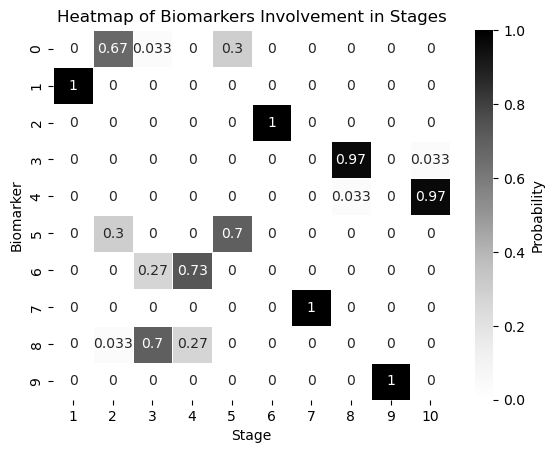

In [270]:
sns.heatmap(data_to_plot_df.transpose(), annot=True, cmap="Greys", linewidths=.5, cbar_kws={'label': 'Probability'})
plt.xlabel('Stage')
plt.ylabel('Biomarker')
plt.title('Heatmap of Biomarkers Involvement in Stages')
plt.show()